In [1]:
!pip install -q kaggle

In [2]:
!pip install pydub

In [3]:
!pip install soundfile

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehak1411","key":"3fb56d2ab6a8ac060eba3f7ae5e46550"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d kongaevans/speaker-recognition-dataset

 98% 227M/231M [00:02<00:00, 110MB/s] 
100% 231M/231M [00:02<00:00, 86.4MB/s]


In [9]:
!mkdir speaker-recognition-dataset

In [10]:
!unzip speaker-recognition-dataset.zip -d speaker-recognition-dataset

Streaming output truncated to the last 5000 lines.
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/556.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/557.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/558.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/559.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/56.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/560.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/561.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/562.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/563.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/564.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/565

IMPORT NECESSARY LIBRARIES

In [11]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal
import os
import pandas as pd
from scipy import stats
from IPython.display import Audio

In [12]:
from sklearn.mixture import GaussianMixture

In [13]:
import joblib
from sklearn.model_selection import train_test_split

In [14]:
from pydub import AudioSegment

Test an audio file

In [15]:
speech_file = "/content/speaker-recognition-dataset/16000_pcm_speeches/Benjamin_Netanyau/1023.wav"
ipd.Audio(filename=speech_file)

In [16]:
speech , sr = librosa.load(speech_file)

In [17]:
print(sr)

22050


# Noise

In [18]:
# getting paths of all noise audios present in the given dataset and storing them in a list

paths=[]
dir_path = r'/content/speaker-recognition-dataset/16000_pcm_speeches'
for x in os.listdir(dir_path):
  if x in ['other','_background_noise_']:
    sub_dir_path = os.path.join(dir_path,x)
    if os.path.isdir(sub_dir_path):
      for y in os.listdir(sub_dir_path):
        file_path = os.path.join(sub_dir_path,y)
        paths.append(file_path)
print(paths)

['/content/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_/dude_miaowing.wav', '/content/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_/doing_the_dishes.wav', '/content/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_/running_tap.wav', '/content/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav', '/content/speaker-recognition-dataset/16000_pcm_speeches/other/pink_noise.wav', '/content/speaker-recognition-dataset/16000_pcm_speeches/other/exercise_bike.wav']


SPLIT NOISE AUDIOS INTO 1-SECOND SEGMENT

In [19]:
import os
import librosa
import soundfile as sf

output_folder = '/content/speaker-recognition-dataset/segmented_audio'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

global_counter = 0
def split_audio(input_file):
    global global_counter
    audio, sr = librosa.load(input_file, sr=None)
    duration = len(audio) / sr
    segment_length = sr

    for i in range(0, int(duration), 1):
        start_sample = i * segment_length
        end_sample = min(start_sample + segment_length, len(audio))
        segment = audio[start_sample:end_sample]  # extracting 1-second segment

        output_file = os.path.join(output_folder, f'segment_{global_counter}.wav')
        sf.write(output_file, segment, sr)  # saving the segment as a wav file
        global_counter += 1

In [20]:
for files in paths:
  split_audio(files)

COLLECTING RAW DATA OF ALL 1-SECOND NOISE CHUNKS

In [21]:
path = r'/content/speaker-recognition-dataset/segmented_audio'
noise_list=[] # list to store the numpy array form (raw data) of the 1-second segments of the noise audio
for y in os.listdir(path):
      file_path = os.path.join(path,y)
      if os.path.isfile(file_path):
        audio_data, sample_rate = librosa.load(file_path)
        noise_list.append(audio_data)

In [22]:
print(len(noise_list))

354


MIX AUDIO AND NOISE

In [23]:
import os
import librosa
import numpy as np
import random
import soundfile as sf

speaker_folder = '/content/speaker-recognition-dataset/16000_pcm_speeches'
exclude_folders = ['other', '_background_noise_','tf_Wav_reader.py']

noise_folder = '/content/speaker-recognition-dataset/segmented_audio'
noise_files = os.listdir(noise_folder)

In [24]:
def load_speaker_audio(speaker_path):
    audio_files = []
    for root, dirs, files in os.walk(speaker_path):
        for file in files:
            if file.endswith('.wav') and not any(folder in root for folder in exclude_folders):
                audio_files.append(os.path.join(root, file))
    return audio_files

In [30]:
mixed_audio_folder = '/content/speaker-recognition-dataset/mixed_audio'
if not os.path.exists(mixed_audio_folder):
    os.makedirs(mixed_audio_folder)

speakers = os.listdir(speaker_folder)
for speaker in speakers:
    speaker_path = os.path.join(speaker_folder, speaker)
    if os.path.isdir(speaker_path):
        audio_files = load_speaker_audio(speaker_path)
        current_speaker_folder = os.path.join(mixed_audio_folder, speaker) # creating a folder for the current speaker in the mixed audio folderr
        if not os.path.exists(current_speaker_folder):
            os.makedirs(current_speaker_folder)

        noise_iter = iter(noise_files) # iterating through all noise files
        for audio_file in audio_files:
            speaker_audio, sr = librosa.load(audio_file, sr=22050)

            try:
                noise_file = next(noise_iter)  # next noise file
            except StopIteration:
                noise_iter = iter(noise_files)  # restarting the iteration when reaching the end
                noise_file = next(noise_iter)  # first noise file

            noise_audio, _ = librosa.load(os.path.join(noise_folder, noise_file), sr=22050)
            mixed_audio = speaker_audio + noise_audio

            output_path = os.path.join(current_speaker_folder, f'{os.path.splitext(os.path.basename(audio_file))[0]}_mixed.wav')
            sf.write(output_path, mixed_audio, sr)

# SPEECH PARAMETERIZATION

In [31]:
dir_path = r'/content/speaker-recognition-dataset/mixed_audio'
minute_speeches = {}
for x in os.listdir(dir_path):
  if x in ['other','_background_noise_']:
    continue
  sub_dir_path = os.path.join(dir_path,x)
  if os.path.isdir(sub_dir_path):
    minute_speech = []
    count = 0
    for y in os.listdir(sub_dir_path):
      if count >= 60:
        break
      file_path = os.path.join(sub_dir_path,y)
      if os.path.isfile(file_path):
        count += 1
        audio_data, sr = librosa.load(file_path)
        minute_speech.extend(audio_data)
    minute_speeches[x] = np.array(minute_speech)

In [32]:
import soundfile as sf

for speaker in minute_speeches.keys():
  sf.write(f"./{speaker}.wav",minute_speeches[speaker],sr)

In [33]:
minute_speeches.keys()

dict_keys(['Jens_Stoltenberg', 'Benjamin_Netanyau', 'Julia_Gillard', 'Nelson_Mandela', 'Magaret_Tarcher'])

In [34]:
Audio(minute_speeches['Nelson_Mandela'],rate=sr)

# VAD

In [36]:
bn=minute_speeches['Benjamin_Netanyau']
js = minute_speeches['Jens_Stoltenberg']
jg=minute_speeches['Julia_Gillard']
mt=minute_speeches['Magaret_Tarcher']
nm=minute_speeches['Nelson_Mandela']

In [37]:
n_fft = 512
win_length = 441
hop_length = 220

In [38]:
vad1 = int(sr/2)
vad2 = int(sr/4)
print(vad1,vad2)

11025 5512


TO CHECK FOR THE THRESHOLDS OF ALL SPEAKERS

In [39]:
mt_test = []
mt_c = []
for x in range(0,int(js.size/sr)):
  zcr = librosa.feature.zero_crossing_rate(js[int(x*sr):int((x+1)*sr)],frame_length=win_length,hop_length=hop_length)[0]
  if (np.var(zcr)*(win_length**2)) >= 500:
    mt_test = np.concatenate([mt_test,js[int(x*sr):int((x+1)*sr)]])
  else:
    mt_c = np.concatenate([mt_c,js[int(x*sr):int((x+1)*sr)]])

In [40]:
Audio(mt_test,rate=sr)

Check mean and variance of any segment from the above 1 minute audios of the speakers just concatenated and visualize that segment's zcr

54.91089108910892
875.28908930497


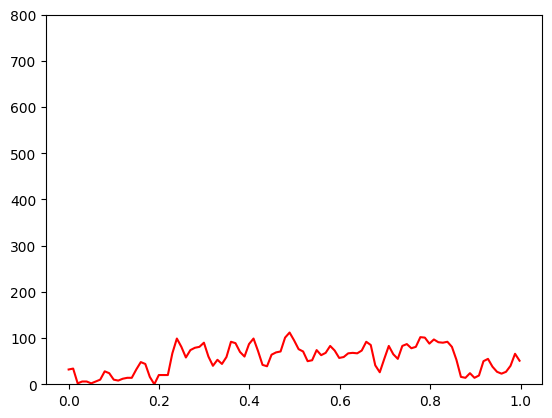

In [43]:
zcr_speech = librosa.feature.zero_crossing_rate(mt_test[int(20*sr):int(21*sr)],frame_length=win_length,hop_length=hop_length)[0]
print(np.mean(zcr_speech)*win_length)
print(np.var(zcr_speech)*(win_length**2))
frames = range(0,zcr_speech.size)
t = librosa.frames_to_time(frames,hop_length=hop_length)

plt.figure()
#librosa.display.waveshow(speech,alpha=0.5)
plt.plot(t,zcr_speech*win_length,color='r')
#plt.title("Nelson Mandela")
plt.ylim((0,800))
plt.show()

In [46]:
Audio(mt_test[3*sr:4*sr],rate=sr)

In [47]:
Audio(mt_c,rate=sr)

In [44]:
n_fft = 512
win_length = 441
hop_length = 220
sr = 22050

Thresholds of all the speakers just found by hit and trial in above cells stored as a dictionary

In [45]:
thresholds = {
    "Benjamin_Netanyau":{"vad1":425},
    "Jens_Stoltenberg":{"vad1":500},
    "Julia_Gillard":{"vad1":700},
    "Magaret_Tarcher":{"vad1":300},
    "Nelson_Mandela":{"vad1":650}}

# Training

WITH NOISE MIXED WITH SPEECH AUDIOS

In [81]:
dir_path = r'/content/speaker-recognition-dataset/mixed_audio'
data = {} # to store keys as speaker and values as paths and speaker data
for speaker in os.listdir(dir_path):
  if speaker in ['other','_background_noise_']:
    continue
  sub_dir_path = os.path.join(dir_path,speaker)
  if os.path.isdir(sub_dir_path):
    file_data = []
    speaker_data = []
    for y in os.listdir(sub_dir_path):
      file_path = os.path.join(sub_dir_path,y)
      if os.path.isfile(file_path):
        file_data.append(file_path)
        speaker_data.append(speaker)
    data[speaker] = pd.DataFrame({'Paths':file_data,'Speaker':speaker_data})
files_data = pd.DataFrame({'Paths':file_data,'Speaker':speaker_data})

WITHOUT NOISE SPEECH AUDIOS

In [112]:
thresholds = {
    "Benjamin_Netanyau":{"vad1":380},
    "Jens_Stoltenberg":{"vad1":380},
    "Julia_Gillard":{"vad1":380},
    "Magaret_Tarcher":{"vad1":150},
    "Nelson_Mandela":{"vad1":1000}}

In [113]:
dir_path = r'/content/speaker-recognition-dataset/16000_pcm_speeches'
data = {} # to store keys as speaker and values as paths and speaker data
for speaker in os.listdir(dir_path):
  if speaker in ['other','_background_noise_','tf_Wav_reader.py']:
    continue
  sub_dir_path = os.path.join(dir_path,speaker)
  if os.path.isdir(sub_dir_path):
    file_data = []
    speaker_data = []
    for y in os.listdir(sub_dir_path):
      file_path = os.path.join(sub_dir_path,y)
      if os.path.isfile(file_path):
        file_data.append(file_path)
        speaker_data.append(speaker)
    data[speaker] = pd.DataFrame({'Paths':file_data,'Speaker':speaker_data})
files_data = pd.DataFrame({'Paths':file_data,'Speaker':speaker_data})

TRAIN TEST SPLIT

In [82]:
train_data = {}
test_data = {}
for speaker in data.keys():
  train_data[speaker],test_data[speaker] = train_test_split(data[speaker],test_size=0.2) # split the datainto 80:20 ratio

 Processing the audio files to extract MFCC features and saving the resulting MFCC data into CSV files for each speaker.

In [83]:
mixed_audio_folder = '/content/speaker-recognition-dataset/MFCC20'
if not os.path.exists(mixed_audio_folder):
    os.makedirs(mixed_audio_folder)

target_dBFS = -16
for speaker in train_data.keys():
  mfcc_data = pd.DataFrame()
  for file_path in train_data[speaker]['Paths']:
    if os.path.isfile(file_path):
      audio = AudioSegment.from_wav(file_path)
      audio.set_frame_rate(sr)
      difference = target_dBFS - audio.dBFS
      audio_adjusted = audio + difference # adjusting the audio volume based on the difference in dBFS.
      output_path = "/content/adjusted20.wav"
      audio_adjusted.export(output_path,format="wav")
      audio, sr = librosa.load(output_path)
      zcr = librosa.feature.zero_crossing_rate(audio,frame_length=win_length,hop_length=hop_length)[0]
      if (np.var(zcr)*(win_length**2)) >= thresholds[speaker]['vad1']:
        mfccs = librosa.feature.mfcc(y=audio,win_length=win_length,n_fft=n_fft,hop_length=hop_length,sr=sr,n_mfcc=13)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs,order=2)
        comprehensive_mfccs = np.concatenate((mfccs,delta_mfccs,delta2_mfccs))
        comprehensive_mfccs = np.transpose(comprehensive_mfccs)
        mfcc_data = pd.concat([mfcc_data,pd.DataFrame(comprehensive_mfccs)])
  mfcc_data['Speaker'] = speaker
  mfcc_data.to_csv(f'/content/speaker-recognition-dataset/MFCC20/{speaker}.csv',index=False)

In [84]:
# mixed_audio_folder = '/content/speaker-recognition-dataset/MFCC205'
# if not os.path.exists(mixed_audio_folder):
#     os.makedirs(mixed_audio_folder)

# target_dBFS = -16
# for speaker in train_data.keys():
#   mfcc_data = pd.DataFrame()
#   for file_path in train_data[speaker]['Paths']:
#     if os.path.isfile(file_path):
#       audio = AudioSegment.from_wav(file_path)
#       audio.set_frame_rate(sr)
#       difference = target_dBFS - audio.dBFS
#       audio_adjusted = audio + difference
#       output_path = "/content/adjusted205.wav"
#       audio_adjusted.export(output_path,format="wav")
#       audio, sr = librosa.load(output_path)
#       zcr = librosa.feature.zero_crossing_rate(audio,frame_length=win_length,hop_length=hop_length)[0]
#       if (np.var(zcr)*(win_length**2)) >= thresholds[speaker]['vad1']:
#         mfccs = librosa.feature.mfcc(y=audio,win_length=win_length,n_fft=n_fft,hop_length=hop_length,sr=sr,n_mfcc=13)
#         delta_mfccs = librosa.feature.delta(mfccs)
#         delta2_mfccs = librosa.feature.delta(mfccs,order=2)
#         mel_spec = librosa.feature.melspectrogram(y=audio,win_length=win_length,n_fft=n_fft,hop_length=hop_length,sr=sr)
#         # Convert power spectrogram to decibel (log scale)
#         log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
#
#         delta_log_mel_spec = librosa.feature.delta(log_mel_spec)
#         comprehensive_mfccs = np.concatenate((mfccs,delta_mfccs,delta2_mfccs,log_mel_spec,delta_log_mel_spec))
#         comprehensive_mfccs = np.transpose(comprehensive_mfccs)
#         mfcc_data = pd.concat([mfcc_data,pd.DataFrame(comprehensive_mfccs)])
#   mfcc_data['Speaker'] = speaker
#   mfcc_data.to_csv(f'/content/speaker-recognition-dataset/MFCC205/{speaker}.csv',index=False)

 Train GMMs for each speaker using their MFCC data

In [85]:
speaker_models = {}
sub_dir_path = "/content/speaker-recognition-dataset/MFCC20"
for y in os.listdir(sub_dir_path):
    file_path = os.path.join(sub_dir_path,y)
    if os.path.isfile(file_path):
      if y.split(sep='.')[-1] == 'csv':
        speaker = y.split(sep='.')[0]
        D = pd.read_csv(file_path)
        X = D.drop(['Speaker'],axis=1) # feature matrix
        speaker_models[speaker] = GaussianMixture(n_components=20,max_iter=10)
        speaker_models[speaker].fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWar

Saving the trained speaker models

In [86]:
mixed_audio_folder = '/content/speaker-recognition-dataset/Models20'
if not os.path.exists(mixed_audio_folder):
    os.makedirs(mixed_audio_folder)

for speaker in speaker_models.keys():
  joblib.dump(speaker_models[speaker],f"/content/speaker-recognition-dataset/Models20/{speaker}_model")

# TESTING

In [114]:
# Load models from file or train them.
speaker_models = {}
dir_path = "/content/speaker-recognition-dataset/Models20"
for y in os.listdir(dir_path):
  file_path = os.path.join(dir_path,y)
  if os.path.isfile(file_path):
    if y.split(sep='.')[-1] == 'model':
      speaker = y.split(sep='.')[0]
      speaker_models[speaker] = joblib.load(file_path)

In [87]:
file_data = []
speaker_data = []
for speaker in test_data.keys():
  for file_path in test_data[speaker]['Paths']:
    if os.path.isfile(file_path):
      file_data.append(file_path)
      speaker_data.append(speaker)
files_data = pd.DataFrame({'Paths':file_data,'Speaker':speaker_data})

In [88]:
shuffled_files = files_data.sample(frac=1)

In [89]:
shuffled_files.shape[0]

1501

In [90]:
random_indexes = [random.randint(0,1500) for _ in range(50)]

In [91]:
def test(file_path):
  if os.path.isfile(file_path):
    audio = AudioSegment.from_wav(file_path)
    audio.set_frame_rate(sr)
    difference = target_dBFS - audio.dBFS
    audio_adjusted = audio + difference
    output_path = "/content/adjusted20.wav"
    audio_adjusted.export(output_path,format="wav")
    audio, _ = librosa.load(output_path)
    mfccs = librosa.feature.mfcc(y=audio,win_length=win_length,n_fft=n_fft,hop_length=hop_length,sr=sr,n_mfcc=13)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs,order=2)
    comprehensive_mfccs = np.concatenate((mfccs,delta_mfccs,delta2_mfccs))
    comprehensive_mfccs = np.transpose(comprehensive_mfccs)
    mfcc_data = pd.DataFrame(comprehensive_mfccs)
  result = {}
  for speaker in speaker_models.keys():
    log_likelihoods = speaker_models[speaker].score_samples(mfcc_data)
    result[speaker] = np.exp(np.mean(log_likelihoods))
  return max(result,key=lambda k: result[k])

Calculates correct number of predictions from random 50 samples 5 times and averages the result so that we can get the average percentage of correctness

In [92]:
corrects=[] # stores correct predictions 5 times
for i in range(0,5): # loop 5 times
  random_indexes = [random.randint(0,1500) for _ in range(50)] # 50 random indices
  predictions = []
  for x in range(0,50):
    predictions.append(test(shuffled_files.loc[random_indexes[x]]['Paths']))
  correct = 0
  for x in range(0,len(predictions)):
    if predictions[x] == shuffled_files.loc[random_indexes[x]]['Speaker']:
      correct += 1
    else:
      print(predictions[x],shuffled_files.loc[random_indexes[x]]['Speaker'])
  corrects.append(correct)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Benjamin_Netanyau Jens_Stoltenberg
Benjamin_Netanyau Jens_Stoltenberg
Jens_Stoltenberg Magaret_Tarcher
Magaret_Tarcher Benjamin_Netanyau
Benjamin_Netanyau Jens_Stoltenberg
Magaret_Tarcher Julia_Gillard
Jens_Stoltenberg Benjamin_Netanyau
Jens_Stoltenberg Nelson_Mandela
Jens_Stoltenberg Julia_Gillard
Benjamin_Netanyau Julia_Gillard


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Magaret_Tarcher Benjamin_Netanyau
Magaret_Tarcher Benjamin_Netanyau
Jens_Stoltenberg Benjamin_Netanyau
Benjamin_Netanyau Nelson_Mandela
Benjamin_Netanyau Jens_Stoltenberg
Julia_Gillard Nelson_Mandela
Jens_Stoltenberg Julia_Gillard
Jens_Stoltenberg Benjamin_Netanyau
Jens_Stoltenberg Nelson_Mandela
Jens_Stoltenberg Benjamin_Netanyau


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Magaret_Tarcher Benjamin_Netanyau
Jens_Stoltenberg Nelson_Mandela
Magaret_Tarcher Jens_Stoltenberg
Jens_Stoltenberg Benjamin_Netanyau
Jens_Stoltenberg Nelson_Mandela
Jens_Stoltenberg Magaret_Tarcher
Jens_Stoltenberg Julia_Gillard
Jens_Stoltenberg Benjamin_Netanyau
Benjamin_Netanyau Magaret_Tarcher
Magaret_Tarcher Benjamin_Netanyau


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Magaret_Tarcher Jens_Stoltenberg
Magaret_Tarcher Benjamin_Netanyau
Benjamin_Netanyau Jens_Stoltenberg
Jens_Stoltenberg Benjamin_Netanyau
Magaret_Tarcher Benjamin_Netanyau


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

Benjamin_Netanyau Jens_Stoltenberg
Magaret_Tarcher Benjamin_Netanyau
Jens_Stoltenberg Benjamin_Netanyau
Jens_Stoltenberg Benjamin_Netanyau
Jens_Stoltenberg Benjamin_Netanyau
Magaret_Tarcher Benjamin_Netanyau


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

In [93]:
corrects

[40, 40, 40, 45, 44]

Average of all the 5 correct predictions

In [94]:
sum(corrects)/5

41.8

# EER

In [97]:
actual_speakers = [shuffled_files.loc[random_indexes[x]]['Speaker'] for x in range(0,len(predictions))]

In [98]:
speakers = ["Benjamin_Netanyau","Jens_Stoltenberg","Julia_Gillard","Magaret_Tarcher","Nelson_Mandela"]
claims = [random.choice(speakers) for x in range(0,50)]

In [103]:
def evaluate(predictions,claims,actual_speakers):
    far = 0 # incorrectly accepted samples
    frr = 0 # incorrectly rejected samples
    errors = 0
    size = len(predictions)
    for x in range(0,size):
      if (predictions[x] != actual_speakers[x]):
        errors += 1
      if (predictions[x] != actual_speakers[x]) and (predictions[x] == claims[x]):
        far += 1
      elif (predictions[x] != actual_speakers[x]) and (claims[x] == actual_speakers[x]):
        frr += 1
    if size > 0:
        ter = (errors / size) * 100 # incorrectly classified samples
        far_rate = (far / size) * 100
        frr_rate = (frr / size) * 100
        print(f"Total error rate: {ter}%\n")
        print(f"False acceptance rate: {far_rate}%\n")
        print(f"False rejection rate: {frr_rate}%\n")
        if frr_rate != 0:
            eer = (far_rate + frr_rate) / 2 # balance between false acceptance and false rejection.
            print(f"Equal error rate: {eer}%") # FAR and FRR are equalance point

In [104]:
evaluate(predictions,claims,actual_speakers)

Total error rate: 12.0%

False acceptance rate: 0.0%

False rejection rate: 0.0%



Load parameters from the saved model

In [96]:
# # Define the directory where the models are saved
# models_dir = "/content/speaker-recognition-dataset/Models64"

# # Create a dictionary to store loaded models
# loaded_models = {}

# # Load models and retrieve parameters
# for model_file in os.listdir(models_dir):
#     if model_file.endswith("_model"):
#         speaker = model_file.split("_model")[0]
#         model_path = os.path.join(models_dir, model_file)

#         # Load the model
#         loaded_model = joblib.load(model_path)
#         loaded_models[speaker] = loaded_model

#         # Retrieve parameters
#         n_components = loaded_model.n_components
#         max_iter = loaded_model.max_iter

#         # Display or use the parameters as needed
#         print(f"Speaker: {speaker}")
#         print(f"Number of Components: {n_components}")
#         print(f"Maximum Iterations: {max_iter}")

# Testing script

In [106]:
def verify(file1, file2):
  speaker1=test(file1)
  speaker2=test(file2)
  if(speaker1==speaker2):
    return True
  else:
    return False

In [110]:
verify('/content/speaker-recognition-dataset/mixed_audio/Jens_Stoltenberg/1003_mixed.wav', '/content/speaker-recognition-dataset/mixed_audio/Nelson_Mandela/1008_mixed.wav')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

False

DOWNLOADING MFCC DATA AND MODELS

In [79]:
!zip -r /content/MFCC_20.zip /content/speaker-recognition-dataset/MFCC20

  adding: content/speaker-recognition-dataset/MFCC20/ (stored 0%)
  adding: content/speaker-recognition-dataset/MFCC20/Magaret_Tarcher.csv (deflated 57%)
  adding: content/speaker-recognition-dataset/MFCC20/Jens_Stoltenberg.csv (deflated 57%)
  adding: content/speaker-recognition-dataset/MFCC20/Julia_Gillard.csv (deflated 57%)
  adding: content/speaker-recognition-dataset/MFCC20/Nelson_Mandela.csv (deflated 57%)
  adding: content/speaker-recognition-dataset/MFCC20/Benjamin_Netanyau.csv (deflated 58%)


In [111]:
!zip -r /content/Models__20.zip /content/speaker-recognition-dataset/Models20

  adding: content/speaker-recognition-dataset/Models20/ (stored 0%)
  adding: content/speaker-recognition-dataset/Models20/Jens_Stoltenberg_model (deflated 39%)
  adding: content/speaker-recognition-dataset/Models20/Benjamin_Netanyau_model (deflated 39%)
  adding: content/speaker-recognition-dataset/Models20/Magaret_Tarcher_model (deflated 39%)
  adding: content/speaker-recognition-dataset/Models20/Julia_Gillard_model (deflated 39%)
  adding: content/speaker-recognition-dataset/Models20/Nelson_Mandela_model (deflated 39%)
